In [60]:
# Introduction
# we'll be exploring a set of data involving some banking information. This set specifically references customer churn, which means whether the customer has
# left the bank institution or not. I'll be clustering the data in an attempt to see if we can identify customers at risk of churning and possibly identify
# areas for a bank to focus on to retain customers.

# What is clustering?
# Clustering is a way we can group similar data points together based on features of the data. We can use this to gleam more information and find trends
# in the data that aren't necessarily obvious at first glance. It's unsupervised, so that means it doesnt rely on the labels of our data in its groupings
# K-means groups the data points based off of their distance from (or proximity to) a specific centroid of a group.
# Agglomerative clustering groups data points besed off of similarity to other data points in a heirarchal system until the data belongs to a single 
# cluster at the top!

# Introduce the data
# Our data set can be found on Kaggle at the following link: https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction
# It includes just over 10000 entries, with the following features: Customer ID, Surname, Credit Score, Geography, Gender, Age, Tenure, Balance, NumOfProducts,
# HasCrCard, IsActiveMember, EstimatedSalary, and Exited. Most of these features are self explanatory, so i'll explain some of the ones that aren't.
# Age: The customer's age, Tenure: The number of years the customer has been with the bank, NumOfProducts: The number of bank products the customer uses
# (e.g., savings account, credit card), HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no), IsActiveMember: Whether the customer is an
# active member, EstimatedSalary: The estimated salary of the customer, Exited: Whether the customer has churned, or left the bank.


# Modelling
# We'll look at both k-means and agglomerative models - I think it'll be good to get the practice with both models!

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.cluster.hierarchy as shc

In [4]:
df = pd.read_csv('Churn_Modelling.csv')
df.describe()

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10002.000000  1.000200e+04  10002.000000  10001.000000  10002.000000   
mean    5001.499600  1.569093e+07    650.555089     38.922311      5.012498   
std     2887.472338  7.193177e+04     96.661615     10.487200      2.891973   
min        1.000000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2501.250000  1.562852e+07    584.000000     32.000000      3.000000   
50%     5001.500000  1.569073e+07    652.000000     37.000000      5.000000   
75%     7501.750000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.000000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts     HasCrCard  IsActiveMember  \
count   10002.000000   10002.000000  10001.000000    10001.000000   
mean    76491.112875       1.530194      0.705529        0.514949   
std     62393.474144       0.581639      0.455827        0.499801   
min         0.000000       1.000000      0.000000        0.000000   
25%         0.000000       1.000000      0.000000        0.000000   
50%     97198.540000       1.000000      1.000000        1.000000   
75%    127647.840000       2.000000      1.000000        1.000000   
max    250898.090000       4.000000      1.000000        1.000000   

       EstimatedSalary        Exited  
count     10002.000000  10002.000000  
mean     100083.331145      0.203759  
std       57508.117802      0.402812  
min          11.580000      0.000000  
25%       50983.750000      0.000000  
50%      100185.240000      0.000000  
75%      149383.652500      0.000000  
max      199992.480000      1.000000

In [5]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

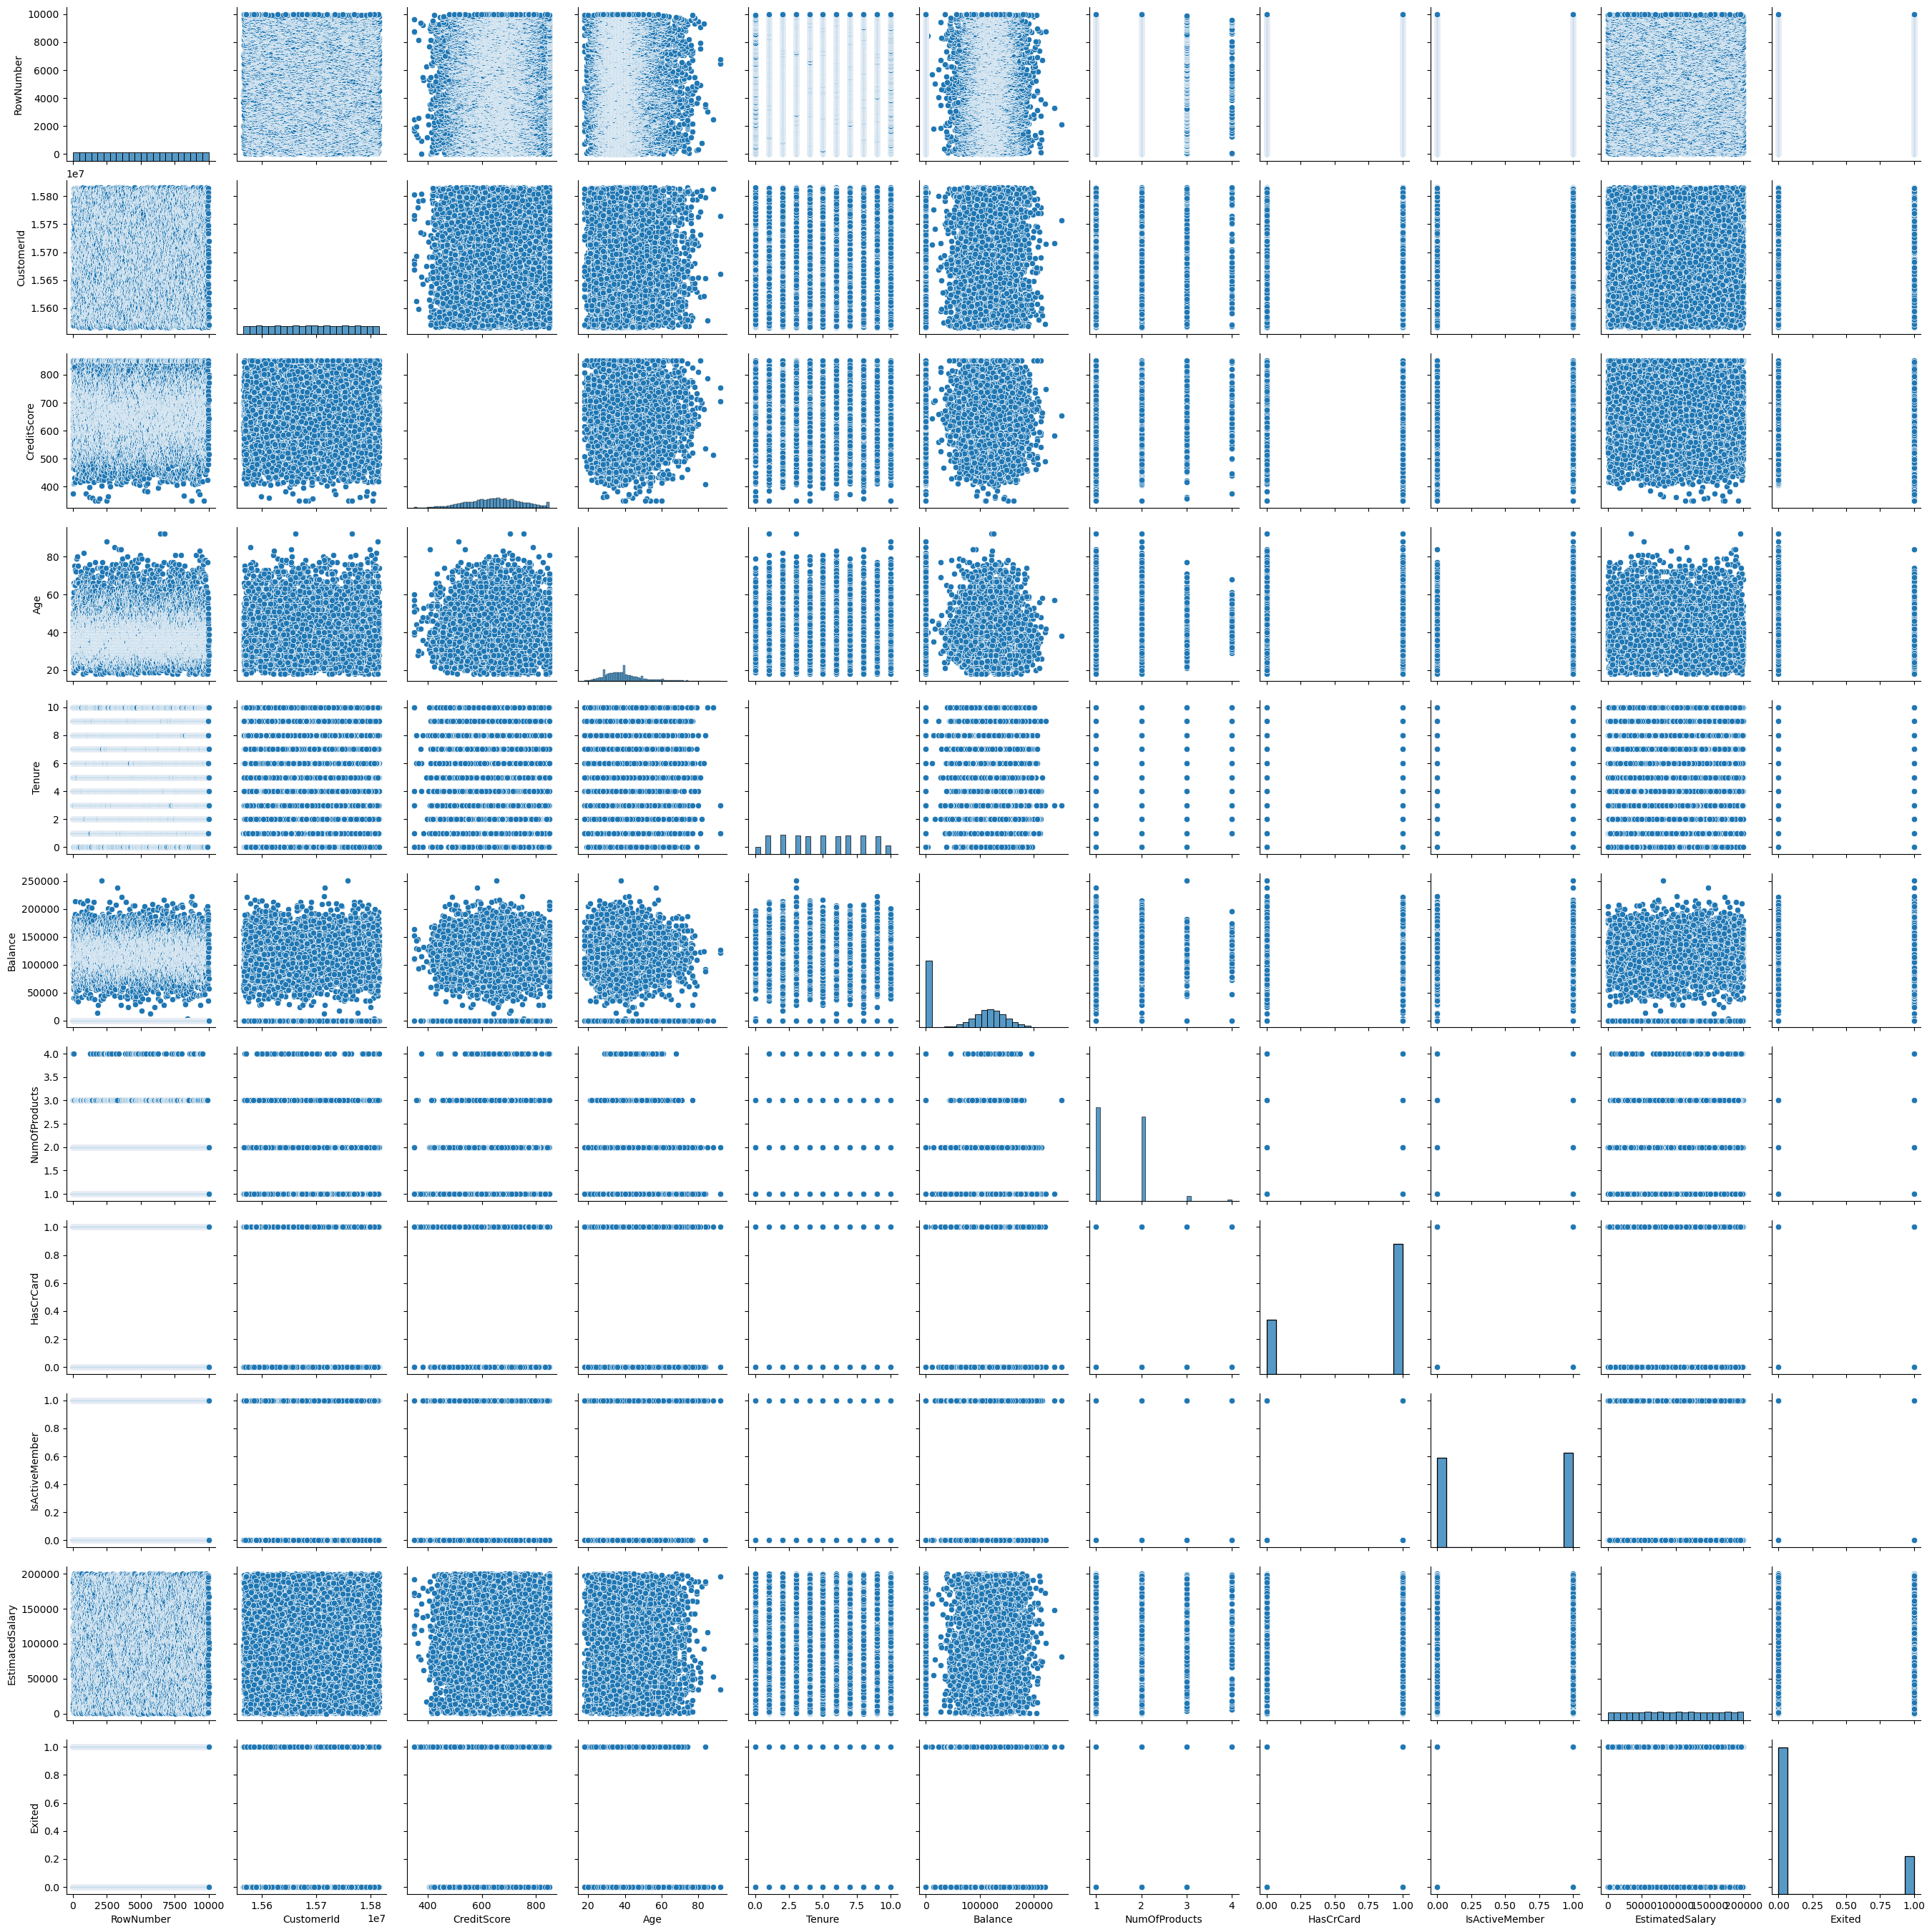

In [6]:
#visualization
# we'll start by looking at the pairplot of the data.
sns.pairplot(df)

In [7]:
# Preprocessing
# We'll drop null values to make life easier
df = df.dropna()
# We'll be dropping the customer id and surname features
df = df.drop(['CustomerId', 'Surname'], axis=1)
# we'll also be encoding the categorical variables - this splits the geographic locations into the 3 different countries with boolean values
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)
#finally, we'll be splitting the dataframe into males and females,
male_df = df[df['Gender'] == 'Male']
male_df = male_df.drop('Gender', axis = 1)
female_df = df[df['Gender'] == 'Female']
female_df = female_df.drop('Gender', axis = 1)

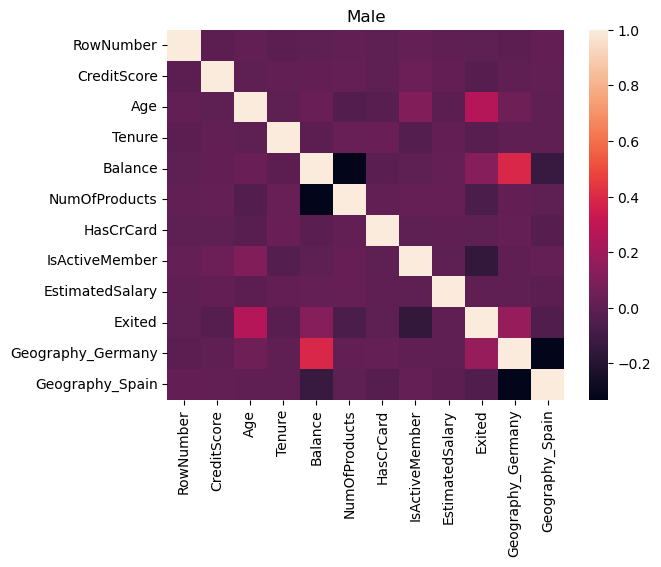

In [8]:
sns.heatmap(male_df.corr())
plt.title('Male')
plt.show()

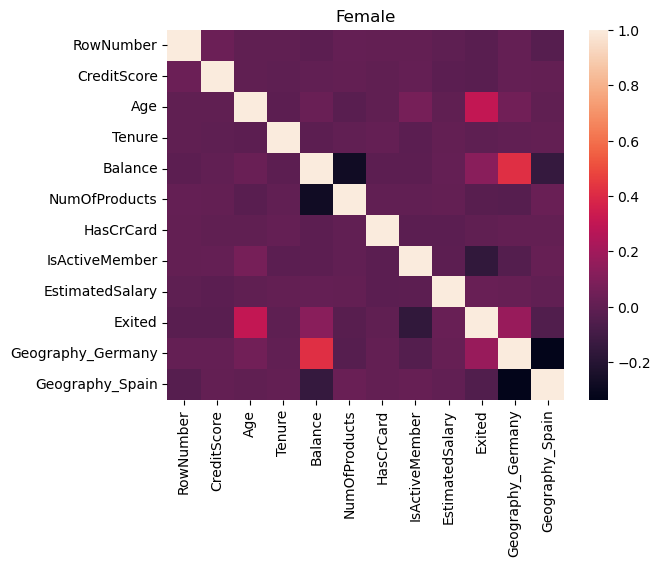

In [10]:
sns.heatmap(female_df.corr())
plt.title('Female')
plt.show()

In [13]:
# To find out how many clusters we'll need, we'll use the elbow method, this is where we find where increasing the number of clusters no longer 
# improves the performance, which looks like an "elbow" - or a sharp turn in our graph. To start with we'll standardize our data.

male_df_std_numerical = male_df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']].values
male_df_std = StandardScaler().fit_transform(male_df_std_numerical)


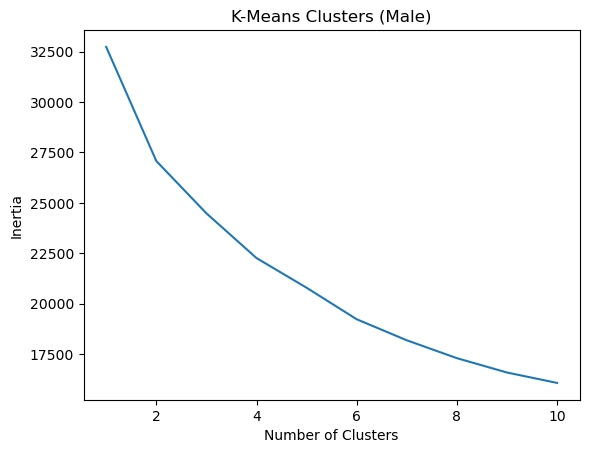

In [14]:
# Now to apply the elbow method. The sharpest turn appears to be at 2 clusters.
inertia = []
for i in range(1,11):
    clusters = KMeans(n_clusters = i, random_state = 42).fit(male_df_std)
    inertia.append(clusters.inertia_)
plt.plot(range(1,11), inertia)
plt.title('K-Means Clusters (Male)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

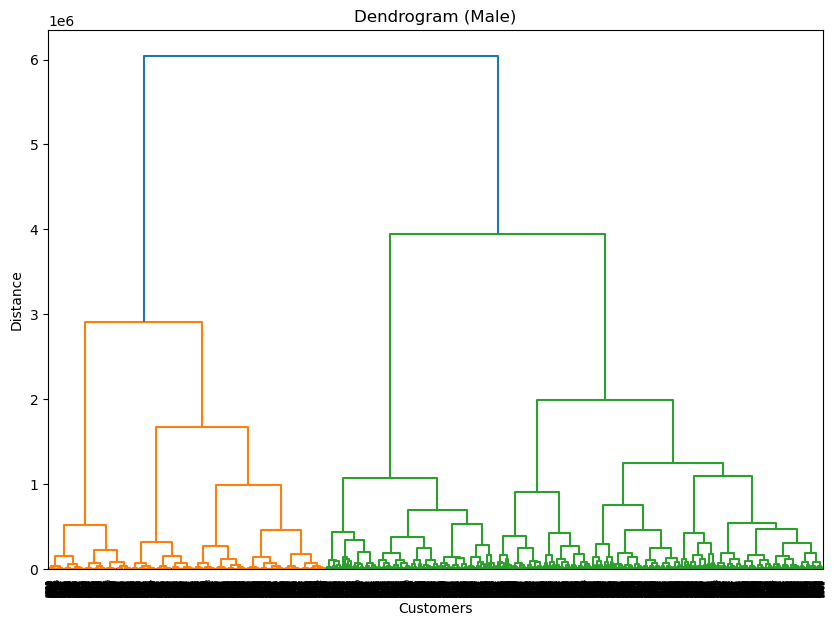

In [15]:
# We can take a look at the dendrogram for our dataset as well. The best amount of clusters appears to be at around 2 as well.
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title('Dendrogram (Male)')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.axhline(y=825, color='r', linestyle='--')
plt.axhline(y=1575, color='r', linestyle='--')
dend = shc.dendrogram(shc.linkage(male_df_std_numerical, method='ward'))

In [16]:
# Here we've applied Principal Component Analysis to reduce the dimensionality of our dataset down to 2 dimensions.
pca = PCA(n_components=2)
male_pca_fit = pca.fit_transform(male_df_std)
male_pca_std = pd.DataFrame(male_pca_fit)

In [73]:
male_agglomerative = AgglomerativeClustering(n_clusters=2,linkage='ward')
male_agglomerative_pred=male_agglomerative.fit_predict(male_df_std)
male_kmeans = KMeans(n_clusters=2, random_state=3).fit(male_df_std_numerical)
male_kmeans_pred = male_kmeans.fit_predict(male_df_std)

Text(0, 0.5, 'PCA Component 2')

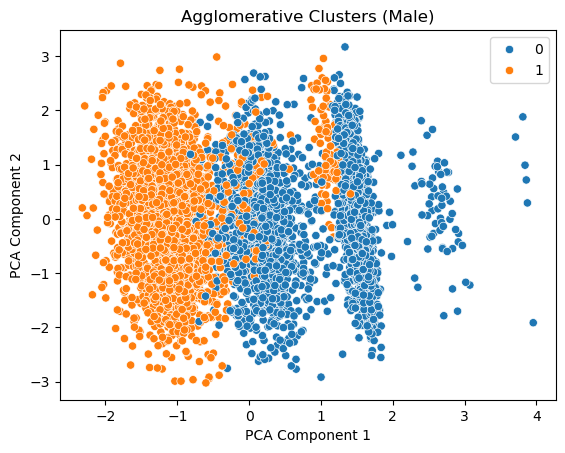

In [75]:
sns.scatterplot(x=male_pca_std[0],y=male_pca_std[1],hue=male_agglomerative_pred)
plt.title('Agglomerative Clusters (Male)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

Text(0, 0.5, 'PCA Component 2')

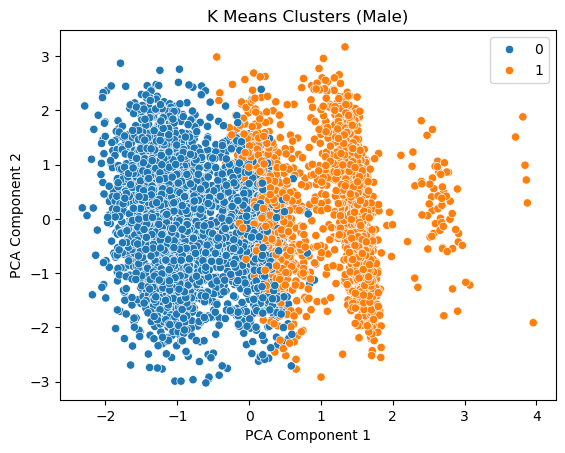

In [77]:
sns.scatterplot(x=male_pca_std[0],y=male_pca_std[1],hue=male_kmeans_pred)
plt.title('K Means Clusters (Male)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

<Axes: xlabel='CreditScore', ylabel='Exited'>

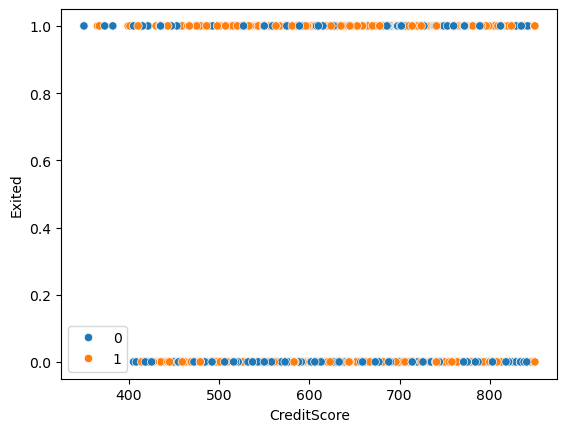

In [79]:
sns.scatterplot(x=male_df['CreditScore'],y=male_df['Exited'],hue=male_agglomerative_pred)

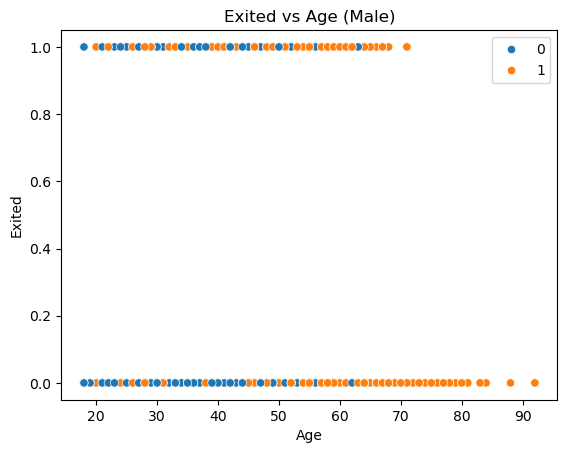

In [81]:
sns.scatterplot(x=male_df['Age'],y=male_df['Exited'],hue=male_agglomerative_pred)
plt.title('Exited vs Age (Male)')
plt.show()

<Axes: xlabel='Tenure', ylabel='Exited'>

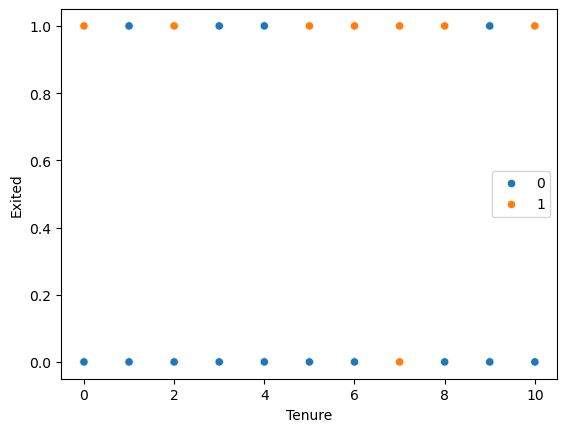

In [83]:
sns.scatterplot(x=male_df['Tenure'],y=male_df['Exited'],hue=male_agglomerative_pred)

<Axes: xlabel='Balance', ylabel='Exited'>

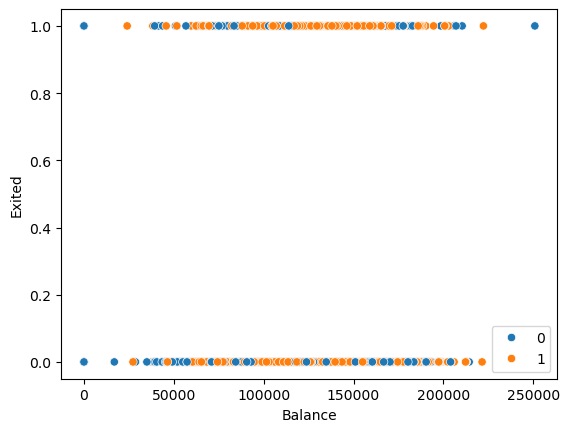

In [85]:
sns.scatterplot(x=male_df['Balance'],y=male_df['Exited'],hue=male_agglomerative_pred)

<Axes: xlabel='EstimatedSalary', ylabel='Exited'>

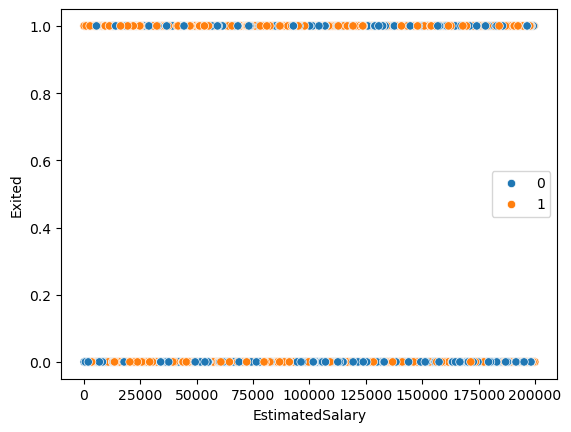

In [87]:
sns.scatterplot(x=male_df['EstimatedSalary'],y=male_df['Exited'],hue=male_agglomerative_pred)

In [109]:
# Male Kmeans and Agglomerative with 4 clusters
male_kmeans4 = KMeans(n_clusters=4, random_state=3).fit(male_df_std_numerical)
male_kmeans_pred4 = male_kmeans4.fit_predict(male_df_std)
male_agglomerative4 = AgglomerativeClustering(n_clusters=4,linkage='ward')
male_agglomerative_pred4 =male_agglomerative4.fit_predict(male_df_std)

Text(0, 0.5, 'PCA Component 2')

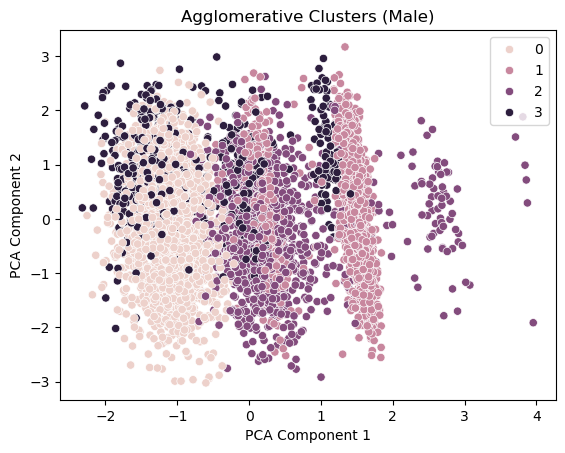

In [105]:
# Male Agglomerative Scatterplot 4 Clusters
sns.scatterplot(x=male_pca_std[0],y=male_pca_std[1],hue=male_agglomerative_pred4)
plt.title('Agglomerative Clusters (Male)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

Text(0, 0.5, 'PCA Component 2')

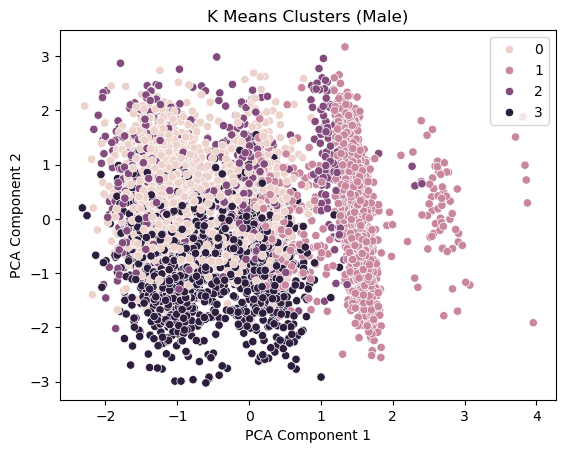

In [111]:
# Male K-Means Scatterplot 4 Clusters
sns.scatterplot(x=male_pca_std[0],y=male_pca_std[1],hue=male_kmeans_pred4)
plt.title('K Means Clusters (Male)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

In [25]:
# To find out how many clusters we'll need, we'll use the elbow method, this is where we find where increasing the number of clusters no longer 
# improves the performance, which looks like an "elbow" - or a sharp turn in our graph. To start with we'll standardize our data.

female_df_std_numerical = female_df[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']].values
female_df_std = StandardScaler().fit_transform(female_df_std_numerical)


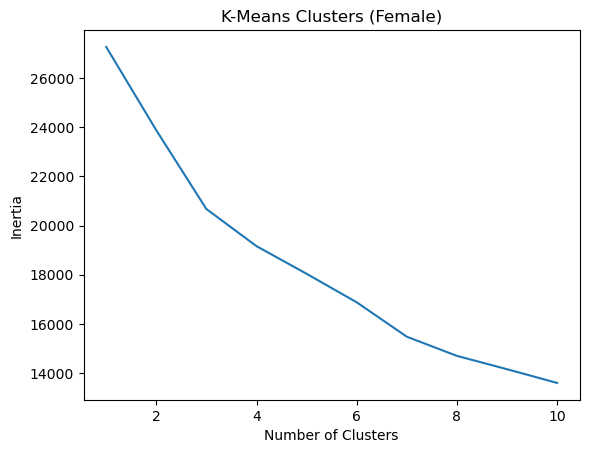

In [26]:
# Now to apply the elbow method. The sharpest turn appears to be at 2 clusters.
inertia = []
for i in range(1,11):
    clusters = KMeans(n_clusters = i, random_state = 42).fit(female_df_std)
    inertia.append(clusters.inertia_)
plt.plot(range(1,11), inertia)
plt.title('K-Means Clusters (Female)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

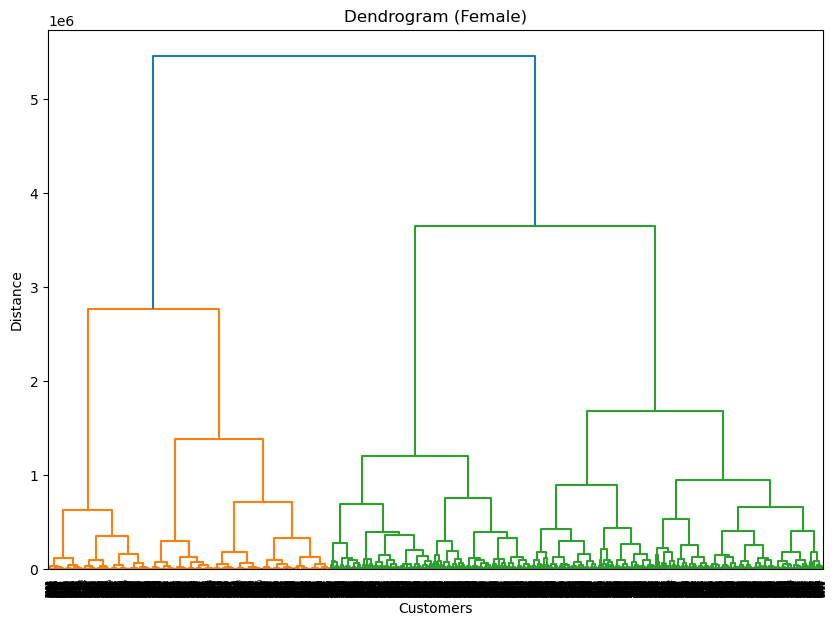

In [27]:
# We can take a look at the dendrogram for our dataset as well. The best amount of clusters appears to be at around 2 as well.
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title('Dendrogram (Female)')
plt.xlabel('Customers')
plt.ylabel('Distance')
plt.axhline(y=825, color='r', linestyle='--')
plt.axhline(y=1575, color='r', linestyle='--')
dend = shc.dendrogram(shc.linkage(female_df_std_numerical, method='ward'))

In [28]:
# Here we've applied Principal Component Analysis to reduce the dimensionality of our dataset down to 2 dimensions.
pca = PCA(n_components=2)
female_pca_fit = pca.fit_transform(female_df_std)
female_pca_std = pd.DataFrame(female_pca_fit)

In [91]:
female_agglomerative = AgglomerativeClustering(n_clusters=3,linkage='ward')
female_agglomerative_pred=female_agglomerative.fit_predict(female_df_std)
female_kmeans = KMeans(n_clusters=3, random_state=3).fit(female_df_std_numerical)
female_kmeans_pred = female_kmeans.fit_predict(female_df_std)

Text(0, 0.5, 'PCA Component 2')

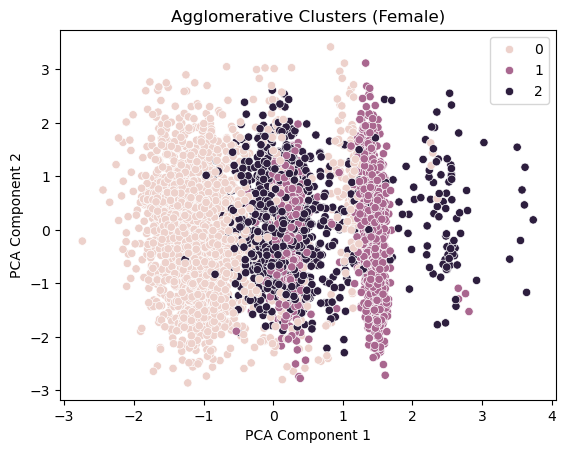

In [69]:
sns.scatterplot(x=female_pca_std[0],y=female_pca_std[1],hue=female_agglomerative_pred)
plt.title('Agglomerative Clusters (Female)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

Text(0, 0.5, 'PCA Component 2')

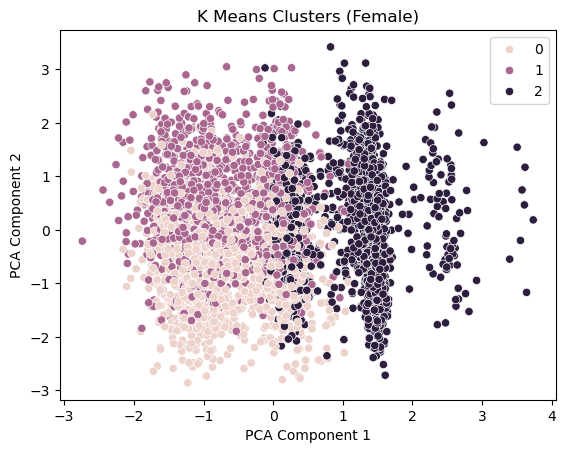

In [71]:
sns.scatterplot(x=female_pca_std[0],y=female_pca_std[1],hue=female_kmeans_pred)
plt.title('K Means Clusters (Female)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

<Axes: xlabel='CreditScore', ylabel='Exited'>

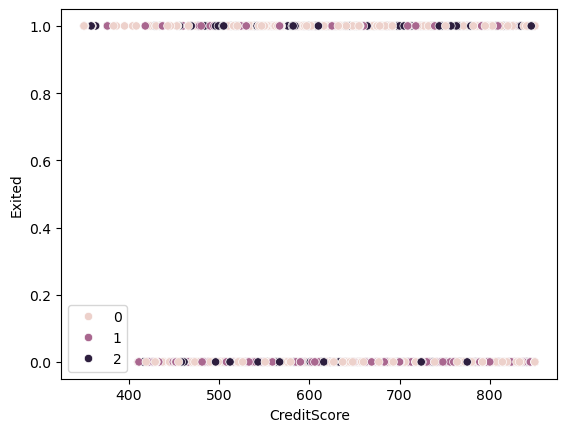

In [113]:
sns.scatterplot(x=female_df['CreditScore'],y=female_df['Exited'],hue=female_agglomerative_pred)

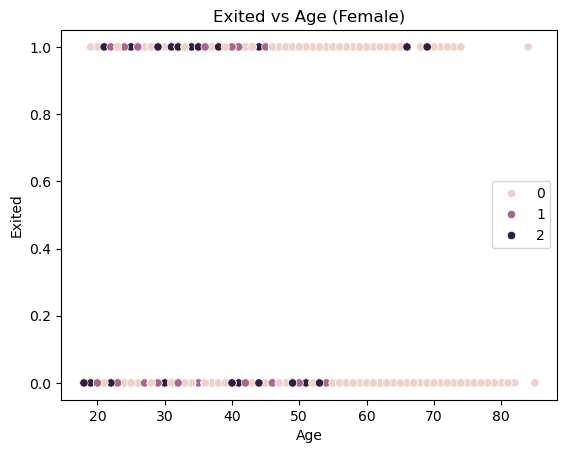

In [115]:
sns.scatterplot(x=female_df['Age'],y=female_df['Exited'],hue=female_agglomerative_pred)
plt.title('Exited vs Age (Female)')
plt.show()

<Axes: xlabel='Tenure', ylabel='Exited'>

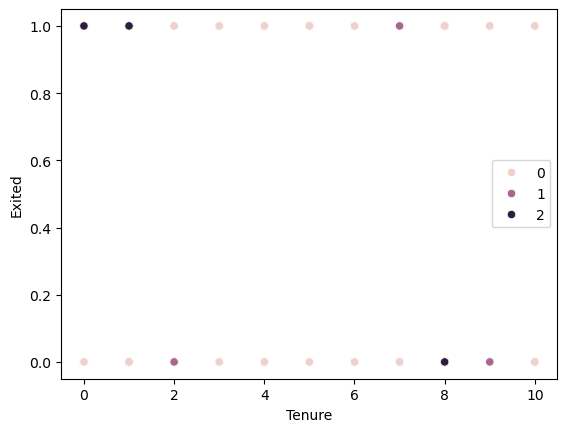

In [117]:
sns.scatterplot(x=female_df['Tenure'],y=female_df['Exited'],hue=female_agglomerative_pred)

<Axes: xlabel='Balance', ylabel='Exited'>

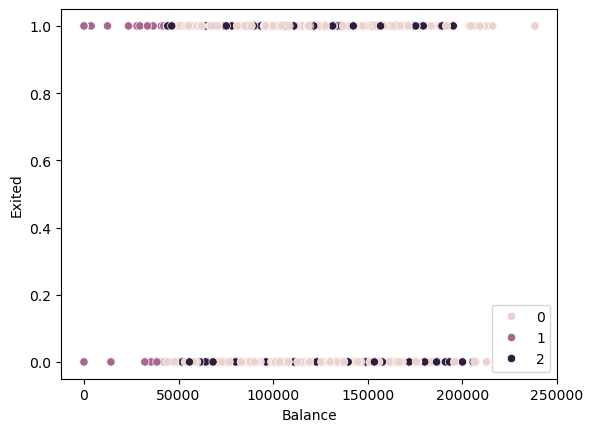

In [119]:
sns.scatterplot(x=female_df['Balance'],y=female_df['Exited'],hue=female_agglomerative_pred)

<Axes: xlabel='EstimatedSalary', ylabel='Exited'>

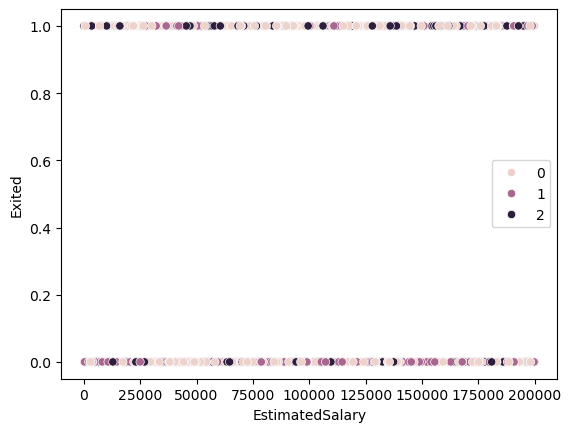

In [121]:
sns.scatterplot(x=female_df['EstimatedSalary'],y=female_df['Exited'],hue=female_agglomerative_pred)